In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install scanpy numpy pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 97.1 MB/s eta 0:00:00


In [6]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse

# =========================
# 1. Load AnnData
# =========================
h5ad_path = "/content/drive/MyDrive/Intro Genome Final project/SEAAD_MTG_RNAseq_2000HVG_subset_demo.h5ad"
adata = sc.read_h5ad(h5ad_path)

print("=== AnnData Loaded ===")
print(adata)
print("obs columns:", adata.obs.columns.tolist())

# =========================
# 2. Labels: 0 = Not AD, 1 = High AD only
# =========================
path_col = "Overall AD neuropathological Change"

control_cats = ["Not AD"]
disease_cats = ["High"]   # ONLY High vs Not AD

mask_valid = adata.obs[path_col].isin(control_cats + disease_cats)
adata_sub = adata[mask_valid].copy()

print("\nCells after keeping only Not AD and High:")
print(adata_sub.n_obs)

label_map = {c: 0 for c in control_cats}
label_map.update({c: 1 for c in disease_cats})
adata_sub.obs["disease_label"] = adata_sub.obs[path_col].map(label_map).astype(int)

print("\nLabel distribution (0=Not AD, 1=High AD) in VALID subset:")
print(adata_sub.obs["disease_label"].value_counts())

# =========================
# 3. Filter by Sex (Male only), then demographic-aware downsampling
#    - keep all controls
#    - for each AgeBin × Race-combo, sample High AD up to #controls
# =========================

sex_to_keep = "Female"   # <-- change to "Female" later for the female model

print(f"\n=== Filtering to {sex_to_keep} only ===")

df_all = adata_sub.obs.copy()

# Clean up Sex column
df_all["Sex"] = df_all["Sex"].astype(str)
df_all.loc[df_all["Sex"].isin(["nan", "NaN", "<NA>"]), "Sex"] = "Unknown"

mask_sex = (df_all["Sex"] == sex_to_keep)
adata_sex = adata_sub[mask_sex].copy()
df = adata_sex.obs.copy()

print(f"Cells after filtering to {sex_to_keep}: {adata_sex.n_obs}")
print("Label distribution in this sex subset:")
print(adata_sex.obs["disease_label"].value_counts())

print(f"\n=== Demographic-aware downsampling within {sex_to_keep} (only removing from High AD) ===")

race_cols = [
    "Race (choice=White)",
    "Race (choice=Black/ African American)",
    "Race (choice=Asian)",
    "Race (choice=American Indian/ Alaska Native)",
    "Race (choice=Native Hawaiian or Pacific Islander)",
    "Race (choice=Unknown or unreported)",
    "Race (choice=Other)",
]

# Age binning
age = df["Age at Death"]
df["AgeBin"] = pd.cut(
    age,
    bins=[0, 60, 70, 80, 90, 130],
    labels=["<=60", "60-70", "70-80", "80-90", ">90"]
)
df["AgeBin"] = df["AgeBin"].astype(str)

# Group by AgeBin + Race-combo (Sex is constant here, all Male)
group_cols = ["AgeBin"] + [c for c in race_cols if c in df.columns]

indices_keep_names = []
np.random.seed(0)  # for reproducibility

for demo_key, idx_names in df.groupby(group_cols).groups.items():
    idx_names = list(idx_names)  # obs_names in this demographic group

    labels_group = adata_sex.obs.loc[idx_names, "disease_label"]
    control_names = labels_group[labels_group == 0].index.to_numpy()  # Not AD
    disease_names = labels_group[labels_group == 1].index.to_numpy()  # High AD

    n_control = len(control_names)
    n_disease = len(disease_names)

    if n_control == 0:
        # skip groups with no controls
        continue

    # keep ALL controls
    indices_keep_names.extend(control_names)

    if n_disease > 0:
        # sample High AD up to the same number as controls (1:1 in this stratum)
        n_keep_disease = min(n_disease, n_control)
        chosen = np.random.choice(disease_names, n_keep_disease, replace=False)
        indices_keep_names.extend(chosen)

indices_keep_names = sorted(set(indices_keep_names))

print(f"Total {sex_to_keep} cells BEFORE demographic downsampling: {adata_sex.n_obs}")
adata_sex_balanced = adata_sex[indices_keep_names].copy()
print(f"Total {sex_to_keep} cells AFTER demographic downsampling:  {adata_sex_balanced.n_obs}")

y_bal = adata_sex_balanced.obs["disease_label"].values
print(f"\nLabel distribution AFTER downsampling (0=Not AD, 1=High AD) for {sex_to_keep}:")
print(pd.Series(y_bal).value_counts())

# =========================
# 4.  normalization check + normalize on the DOWNSAMPLED sex-specific data
# =========================
X_sample = adata_sex_balanced.X

if issparse(X_sample):
    X_sample = X_sample[:1000].toarray()
else:
    X_sample = np.asarray(X_sample[:1000])

max_val = X_sample.max()
is_integer_like = np.allclose(X_sample, np.round(X_sample))

print("\n=== Normalization Check (after downsampling, sex-specific) ===")
print("Sample max value in X:", max_val)
print("All values integer-like (in sample):", bool(is_integer_like))

needs_normalization = bool(is_integer_like and max_val > 50)

if needs_normalization:
    print("➡ Data looks like raw counts → applying normalize_total + log1p + scale")
    sc.pp.normalize_total(adata_sex_balanced, target_sum=1e4)
    sc.pp.log1p(adata_sex_balanced)
    sc.pp.scale(adata_sex_balanced, max_value=10)
else:
    print("➡ Data seems already normalized/log-scaled → skipping extra normalization")

# =========================
# 5. Save sex-specific balanced + normalized AnnData
# =========================
out_path = f"/content/drive/MyDrive/Intro Genome Final project/SEAAD_MTG_2000HVG_High_vs_NotAD_{sex_to_keep}_balanced_normalized.h5ad"

print(f"\nSaving {sex_to_keep}-only balanced + normalized dataset to:\n{out_path}")
adata_sex_balanced.write(out_path, compression="gzip")

print(" Saved successfully!")


=== AnnData Loaded ===
AnnData object with n_obs × n_vars = 1378211 × 2000
    obs: 'Overall AD neuropathological Change', 'Age at Death', 'Sex', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
obs columns: ['Overall AD neuropathological Change', 'Age at Death', 'Sex', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino']

Cells after keeping only Not AD and High:
701490

Label distribution (0=Not AD, 1=High AD) in

/tmp/ipython-input-78109582.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for demo_key, idx_names in df.groupby(group_cols).groups.items():


Total Female cells BEFORE demographic downsampling: 448632
Total Female cells AFTER demographic downsampling:  168974

Label distribution AFTER downsampling (0=Not AD, 1=High AD) for Female:
0    91485
1    77489
Name: count, dtype: int64

=== Normalization Check (after downsampling, sex-specific) ===
Sample max value in X: 2332.0
All values integer-like (in sample): True
➡ Data looks like raw counts → applying normalize_total + log1p + scale


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)



Saving Female-only balanced + normalized dataset to:
/content/drive/MyDrive/Intro Genome Final project/SEAAD_MTG_2000HVG_High_vs_NotAD_Female_balanced_normalized.h5ad
 Saved successfully!


/usr/local/lib/python3.12/dist-packages/anndata/_io/utils.py:243: FutureWarning: Forward slashes will be disallowed in h5 stores in the next minor release
  return func(*args, **kwargs)


Using device: cuda
Using learning_rate=0.0001, max_epochs=100, patience=5, dropout=0.4, hidden=(64, 32), weight_decay=0.001

=== AnnData Loaded (sex-specific) ===
AnnData object with n_obs × n_vars = 168974 × 2000
    obs: 'Overall AD neuropathological Change', 'Age at Death', 'Sex', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'disease_label'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p'
obs columns: ['Overall AD neuropathological Change', 'Age at Death', 'Sex', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (ch

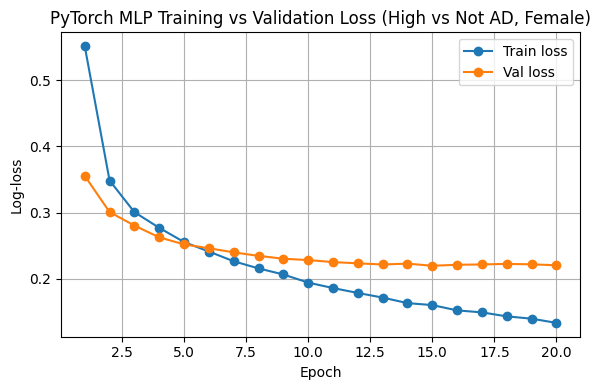

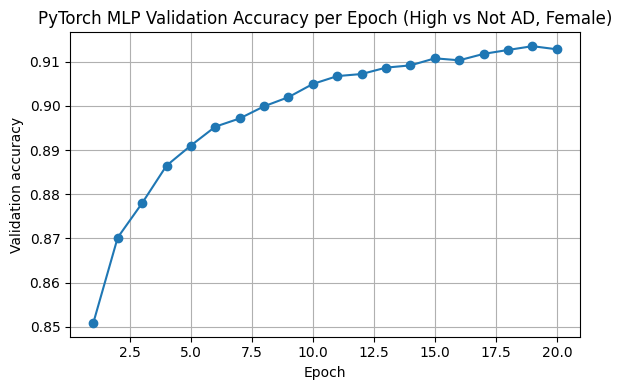

In [7]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    log_loss,
    accuracy_score,
)

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# =========================
# HYPERPARAMETERS
# =========================
learning_rate = 1e-4      # lower LR = gentler training
max_epochs    = 100
patience      = 5         # patience for early stopping (on val loss)
batch_size    = 128
hidden_sizes  = (64, 32)  # smaller model → less capacity
dropout_p     = 0.4      # strong dropout
weight_decay  = 1e-3      # L2 regularization

sex_to_keep = "Female"  # <-- keep in sync with preprocessing script

checkpoint_path = f"/content/drive/MyDrive/Intro Genome Final project/best_mlp_high_vs_notAD_{sex_to_keep}.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(
    f"Using learning_rate={learning_rate}, max_epochs={max_epochs}, "
    f"patience={patience}, dropout={dropout_p}, hidden={hidden_sizes}, "
    f"weight_decay={weight_decay}"
)

# =========================
# 1. Load sex-specific balanced + normalized AnnData
# =========================
h5ad_path = f"/content/drive/MyDrive/Intro Genome Final project/SEAAD_MTG_2000HVG_High_vs_NotAD_{sex_to_keep}_balanced_normalized.h5ad"
adata = sc.read_h5ad(h5ad_path)

print("\n=== AnnData Loaded (sex-specific) ===")
print(adata)
print("obs columns:", adata.obs.columns.tolist())

if "disease_label" not in adata.obs.columns:
    raise ValueError("Expected 'disease_label' in adata.obs but it was not found.")

# =========================
# 2. Features X and labels y
# =========================
X = adata.X
y = adata.obs["disease_label"].values.astype(np.int64)  # 0 = Not AD, 1 = High AD

if issparse(X):
    X = X.toarray()
X = np.asarray(X, dtype=np.float32)

print("\nFull data shapes (sex-specific):")
print("X:", X.shape, " y:", y.shape)
print("Label distribution:")
print(pd.Series(y).value_counts())

# =========================
# 3. Train / Val / Test split (60 / 20 / 20)
# =========================
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,      # 0.25 of 0.8 = 0.2
    random_state=42,
    stratify=y_trainval
)

print("\nShapes:")
print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

print("\nLabel counts per split:")
for name, yy in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    print(name)
    print(pd.Series(yy).value_counts())

# =========================
# 4. Build PyTorch datasets & loaders
# =========================
X_train_t = torch.from_numpy(X_train)
X_val_t   = torch.from_numpy(X_val)
X_test_t  = torch.from_numpy(X_test)

y_train_t = torch.from_numpy(y_train)
y_val_t   = torch.from_numpy(y_val)
y_test_t  = torch.from_numpy(y_test)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

# =========================
# 5. Define MLP model (GPU) with dropout
# =========================
input_dim = X.shape[1]
hidden1, hidden2 = hidden_sizes

class MLP(nn.Module):
    def __init__(self, in_dim, h1, h2, p_drop=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h2, 1)  # output logit
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, hidden1, hidden2, p_drop=dropout_p).to(device)
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

print("\nModel:")
print(model)

# =========================
# 6. Training loop with early stopping on VAL LOSS + checkpoint
# =========================
train_losses = []
val_losses   = []
val_accs     = []

best_val_loss = np.inf
best_epoch    = -1
best_state    = None
epochs_no_improve = 0

def evaluate(loader):
    """Compute loss, accuracy, probabilities, and labels on a loader."""
    model.eval()
    all_logits = []
    all_labels = []
    total_loss = 0.0
    n_samples  = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device).float().view(-1, 1)

            logits = model(xb)
            loss   = criterion(logits, yb)

            bs = yb.size(0)
            total_loss += loss.item() * bs
            n_samples  += bs

            all_logits.append(logits.cpu())
            all_labels.append(yb.cpu())

    avg_loss = total_loss / n_samples
    all_logits = torch.cat(all_logits).view(-1)
    all_labels = torch.cat(all_labels).view(-1)

    probs = torch.sigmoid(all_logits)
    preds = (probs >= 0.5).long()
    acc = (preds == all_labels.long()).float().mean().item()

    return avg_loss, acc, probs.numpy(), all_labels.numpy()

print("\n=== Training on GPU (if available) with Early Stopping on Validation LOSS ===")
for epoch in range(1, max_epochs + 1):
    print(f"\nEpoch {epoch}/{max_epochs}")
    model.train()
    total_train_loss = 0.0
    n_train_samples  = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()

        # Gradient clipping for extra stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        bs = yb.size(0)
        total_train_loss += loss.item() * bs
        n_train_samples  += bs

    avg_train_loss = total_train_loss / n_train_samples

    # Evaluate on validation set
    val_loss, val_acc, val_probs, val_labels_np = evaluate(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train loss: {avg_train_loss:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

    # Early stopping based on VAL LOSS (minimize)
    if val_loss < best_val_loss - 1e-4:  # small tolerance
        best_val_loss = val_loss
        best_epoch    = epoch
        best_state    = model.state_dict()
        epochs_no_improve = 0

        # Save checkpoint
        torch.save(best_state, checkpoint_path)
        print(f"  ↳ New best model found — checkpoint saved to: {checkpoint_path}")
    else:
        epochs_no_improve += 1
        print(f"  ↳ No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch} epochs (best epoch: {best_epoch})")
        break

if best_state is not None:
    model.load_state_dict(best_state)
else:
    print("\n[Warning] Early stopping never improved; using final model.")

print(f"\nBest validation loss: {best_val_loss:.4f} at epoch {best_epoch}")
print(f"Best checkpoint is saved at: {checkpoint_path}")

# =========================
# 7. Evaluate BEST model on VAL and TEST
# =========================
# VAL
val_loss, val_acc, val_probs, val_labels_np = evaluate(val_loader)
val_preds = (val_probs >= 0.5).astype(int)

print(f"\n=== BEST MODEL ({sex_to_keep}): VAL SET PERFORMANCE ===")
print(classification_report(val_labels_np, val_preds, digits=4))
try:
    print("VAL ROC-AUC:", roc_auc_score(val_labels_np, val_probs))
except ValueError:
    print("VAL ROC-AUC: could not be computed.")
print("VAL log-loss:", log_loss(val_labels_np, val_probs))
print("VAL accuracy:", val_acc)
print("VAL Confusion matrix:")
print(confusion_matrix(val_labels_np, val_preds))

# TEST
test_loss, test_acc, test_probs, test_labels_np = evaluate(test_loader)
test_preds = (test_probs >= 0.5).astype(int)

print(f"\n=== BEST MODEL ({sex_to_keep}): TEST SET PERFORMANCE ===")
print(classification_report(test_labels_np, test_preds, digits=4))
try:
    print("TEST ROC-AUC:", roc_auc_score(test_labels_np, test_probs))
except ValueError:
    print("TEST ROC-AUC: could not be computed.")
print("TEST log-loss:", log_loss(test_labels_np, test_probs))
print("TEST accuracy:", test_acc)
print("TEST Confusion matrix:")
print(confusion_matrix(test_labels_np, test_preds))

# =========================
# 8. Training curves
# =========================
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_losses, marker='o', label="Train loss")
plt.plot(epochs_range, val_losses,   marker='o', label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Log-loss")
plt.title(f"PyTorch MLP Training vs Validation Loss (High vs Not AD, {sex_to_keep})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, val_accs, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title(f"PyTorch MLP Validation Accuracy per Epoch (High vs Not AD, {sex_to_keep})")
plt.grid(True)
plt.tight_layout()
plt.show()



=== Running SHAP to estimate gene importance ===
Using 200 background samples and 10000 evaluation samples for SHAP.
SHAP values shape: (10000, 2000, 1)
Squeezed SHAP values shape: (10000, 2000)

Top 20 genes by SHAP:
          gene  shap_importance
0       MT-ND3         1.292844
1    LINC01515         0.751201
2    MTRNR2L12         0.352543
3       HSPA1B         0.314896
4   AP001977.1         0.274592
5   AL358944.1         0.259475
6        HSPB1         0.240946
7     AQP4-AS1         0.230337
8       COL5A2         0.223763
9        CDH13         0.217722
10  AC004158.1         0.206891
11   LINC00326         0.200326
12  AC120193.1         0.200034
13       PDZD2         0.193099
14  AC068587.4         0.188903
15     TMEM163         0.177126
16    SLC22A10         0.175642
17       LRRK1         0.173191
18       NXPH1         0.172775
19       TMTC2         0.172049

Saved SHAP top genes to: /content/drive/MyDrive/Intro Genome Final project/top20_shap_Female.csv


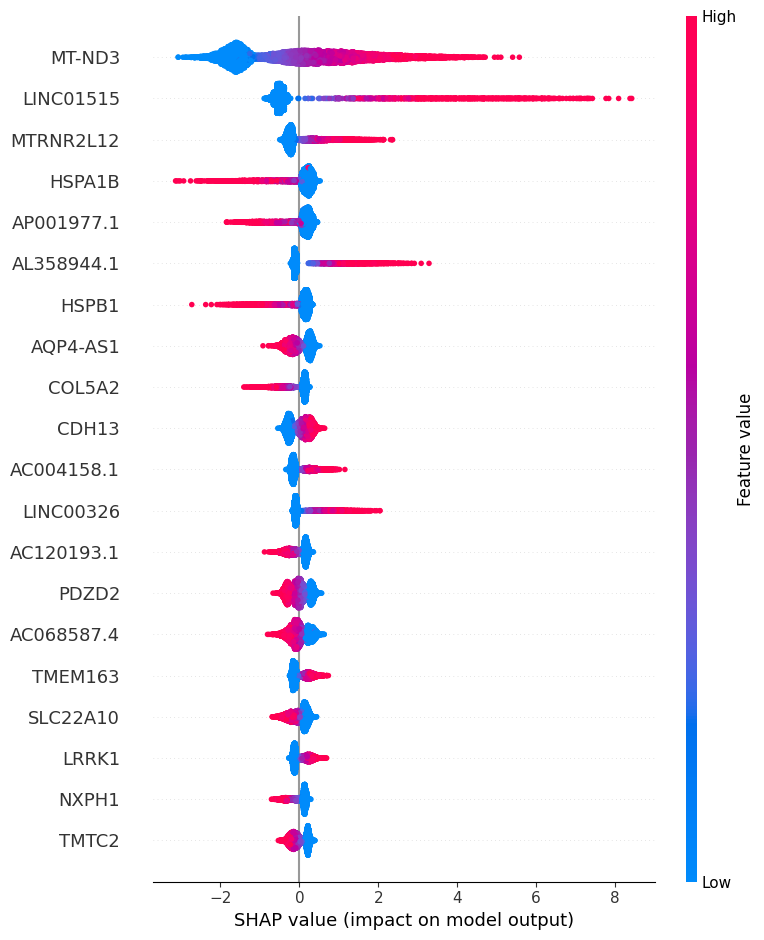

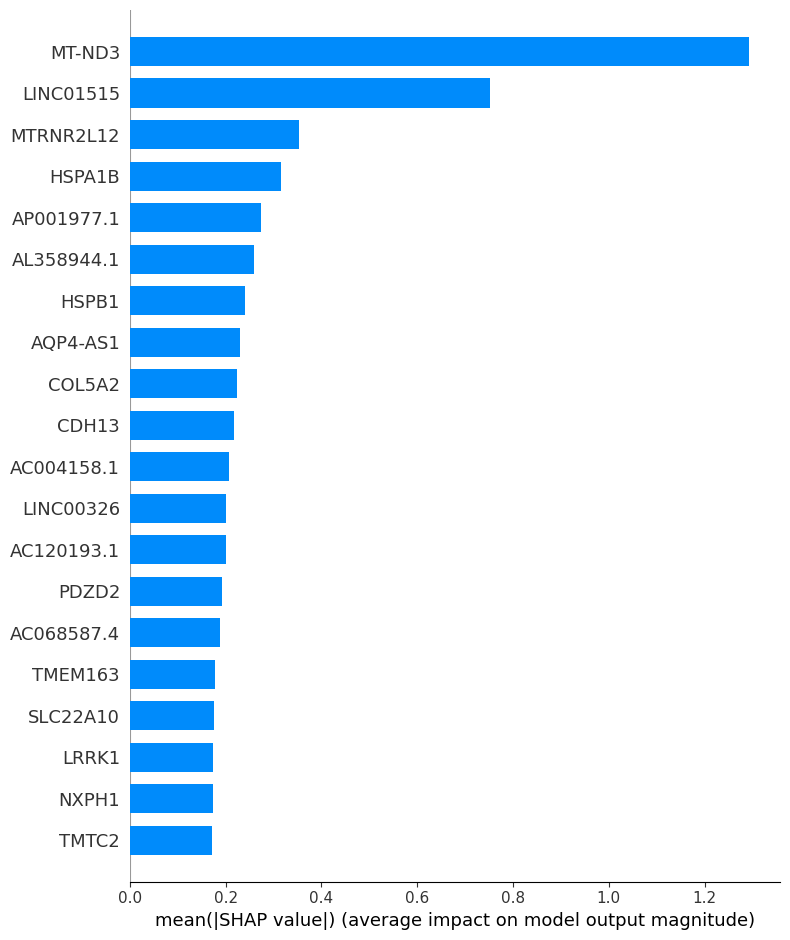

In [10]:
# =========================
# 9. SHAP analysis for gene importance (Female model)
# =========================
try:
    import shap
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "shap"])
    import shap

print("\n=== Running SHAP to estimate gene importance ===")

model.eval()

# ---- 1) Background and evaluation sets ----
# keep sizes modest so it runs fast
background_size = min(200, X_train.shape[0])
eval_size       = min(10000, X_test.shape[0])

background_np = X_train[:background_size]
X_eval_np     = X_test[:eval_size]

background_t = torch.from_numpy(background_np).to(device)
X_eval_t     = torch.from_numpy(X_eval_np).to(device)

print(f"Using {background_size} background samples and {eval_size} evaluation samples for SHAP.")

# ---- 2) Build DeepExplainer and compute SHAP values ----
explainer = shap.DeepExplainer(model, background_t)
raw_shap  = explainer.shap_values(X_eval_t)

# Handle different possible return types
if isinstance(raw_shap, list):
    sv = raw_shap[0]
else:
    sv = raw_shap

if torch.is_tensor(sv):
    shap_values = sv.detach().cpu().numpy()
else:
    shap_values = np.asarray(sv)

X_eval_np = X_eval_t.detach().cpu().numpy()

print("SHAP values shape:", shap_values.shape)  # e.g. (n_samples, n_genes, 1)

# If there's a singleton output dimension, squeeze it
if shap_values.ndim == 3 and shap_values.shape[-1] == 1:
    shap_values = shap_values[..., 0]  # -> (n_samples, n_genes)
    print("Squeezed SHAP values shape:", shap_values.shape)

# ---- 3) Aggregate importance per gene ----
mean_abs_shap = np.mean(np.abs(shap_values), axis=0).astype(float)  # shape: (n_genes,)

gene_names = np.array(adata.var_names)

top_n = 20
top_idx = np.argsort(mean_abs_shap)[::-1][:top_n]

# Build DataFrame-style table like you used before
top_genes_df = pd.DataFrame({
    "gene": gene_names[top_idx],
    "shap_importance": mean_abs_shap[top_idx]
})

print("\nTop 20 genes by SHAP:")
print(top_genes_df.to_string(index=True))

# (optional) save to CSV for plotting later
csv_path = f"/content/drive/MyDrive/Intro Genome Final project/top20_shap_{sex_to_keep}.csv"
top_genes_df.to_csv(csv_path, index=False)
print(f"\nSaved SHAP top genes to: {csv_path}")

# ---- 4) SHAP summary plots ----
shap.initjs()

# Beeswarm plot: direction + magnitude per gene
shap.summary_plot(
    shap_values,
    X_eval_np,
    feature_names=gene_names,
    max_display=20
)

# Bar plot: global importance ranking
shap.summary_plot(
    shap_values,
    X_eval_np,
    feature_names=gene_names,
    plot_type="bar",
    max_display=20
)



Confusion Matrix (Percentages, row-normalized):
[[92.22276876  7.77723124]
 [ 9.69157311 90.30842689]]


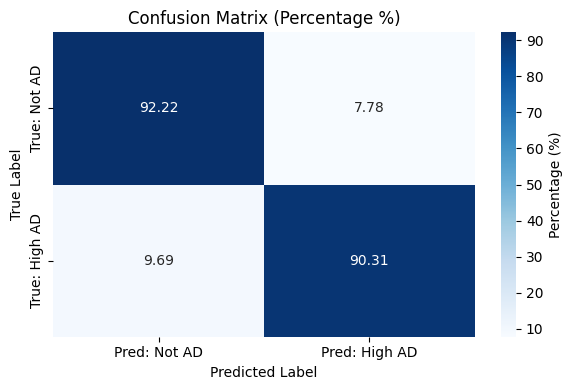

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# y_test_np = true labels
# test_preds = predicted labels (0 or 1)

# ==========================
# 1) Build confusion matrix
# ==========================
cm = confusion_matrix(test_labels_np, test_preds)  # raw counts

# Convert to row-wise percentages
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

print("\nConfusion Matrix (Percentages, row-normalized):")
print(cm_percent)

# ==========================
# 2) Pretty heatmap (percentages)
# ==========================
plt.figure(figsize=(6,4))
sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=["Pred: Not AD", "Pred: High AD"],
    yticklabels=["True: Not AD", "True: High AD"],
    cbar_kws={'label': 'Percentage (%)'}
)
plt.title("Confusion Matrix (Percentage %)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
